This to take care while working with GANN: 
1. scale input in range(-1,1)
2. Use Tanh as activation function 
3. Use leaky relu instead of ReLU since Relu makes gradient = 0 when value<= 0
      MEANS WHEN <= 0 WE'LL GIVE A*VALUE, WHERE 0 < A < 1
4. Noise should be sampled from Gaussian distribution mean = 0, SD = 1
5. One sided label smoothing for discriminator 
6. Use Adam as optimizer

NOTE : TPU takes more time on small batch sizes, it needs larger batch size 

Also they require bit more time in some starting iteration to come up to get pace

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [ ]:
(train,_),(_,_) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
train.shape

(60000, 28, 28)

In [ ]:
train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

First Step is to normalize our dataset

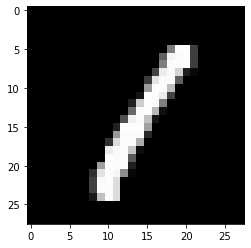

In [ ]:
plt.imshow(train[3],cmap='gray')

We are using Dense layers so we need to linearize image into single dimentional vector 

In [ ]:
train = train.reshape((train.shape[0],-1))
train.shape

(60000, 784)

In [ ]:
train = (train.astype('float32') - 127.5)/127.5
print(max(train[0]))
print(min(train[0]))

1.0
-1.0


now defining some model parameters
1. Epochs used for training
2. Batch size at each traning
3. Split of batch size by generator and real images to be given to discriminator
4. Iterations to complete one iteratoin 
5. Optimizer and it's parameters suitable for GANN : lr = 1e-4 and beta_l = .5
6. Input Noise dimention for discriminator

In [ ]:
from keras.optimizers import adam_v2

In [ ]:
EPOCHS = 50
BATCH_SIZE = 256
NO_BATCHES = int((train.shape[0])/BATCH_SIZE)
H_BATCH = 128
NOISE = 100
optim = adam_v2.Adam(learning_rate = 2e-4,beta_1=.5)

creating MODEL : 
1. Discriminator 
2. Generator 

Here both are made from sequencial models, using dense layers, relu and tanh as activation functions

We have 2 type of training phases, first noise -> generator -> discriminator -> output loss

secondly: realImage->discriminator->output loss

After then both losses are combined to train discriminator in equal proportitions

Important to use Binary_crossentropy as loss 

---
Generator  
* Input(100)
* Dense(256) : Relu
* Dense(512) : Relu
* Dense(1024) : Relu
* Dense(784) : tanh ## getting normalized values 

Discriminator
* Input((784,)
* Dense(512)
* Dense(256)
* Dense(1) with sigmoid activation to get output probabilityes





In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dense,Activation,Input
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import softmax,tanh

In [ ]:
leakyRelu = LeakyReLU(.2)

In [ ]:
## generator 

generator = Sequential()
generator.add(Dense(256,input_shape = (NOISE,)))
generator.add(Activation(leakyRelu))
generator.add(Dense(512))
generator.add(Activation(leakyRelu))
generator.add(Dense(1026))
generator.add(Activation(leakyRelu))
generator.add(Dense(784))
generator.add(Activation(tanh))

In [ ]:
generator.compile(loss='binary_crossentropy',optimizer=optim)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1026)              526338    
                                                                 
 activation_2 (Activation)   (None, 1026)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

In [ ]:
#### creating discriminator mode

discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(Activation(leakyRelu))
discriminator.add(Dense(128))
discriminator.add(Activation(leakyRelu))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=optim)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 activation_5 (Activation)   (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 467,713
Trainable params: 467,713
Non-trainable params: 0
_________________________________________________________________


To Train Generator 

We need path from noise->generator->generatedImages->discriminator->loss/output

In this path discriminator needs to be turned off so that discriminator doesn't get trained

Joining 2 models are done by Functional API model(), that can give computational graph for keras to compute gradients and pass loss to desired position

In [ ]:
gan_input = Input(shape=(NOISE,))
generatedImage = generator(gan_input)
discriminator.trainable = False
gan_output = discriminator(generatedImage)  ## they provides a layer instead of input and taken generatedImage layer as input
model = Model(gan_input,gan_output) ## this combines all layers that needs to be connected with each other 
model.compile(loss="binary_crossentropy",optimizer=optim)
## compiling remembers discriminator has not to be trained when model is begin trained
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1488946   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 467713    
                                                                 
Total params: 1,956,659
Trainable params: 1,488,946
Non-trainable params: 467,713
_________________________________________________________________


In [ ]:
def saveImage(epoch): 
  samples=100
  noise = np.random.normal(0,1,size=(samples,NOISE))
  generatedImages = generator.predict(noise)
  generatedImages = generatedImages.reshape((samples,28,28))
  generatedImages = (generatedImages + 127.5)*127.5
  plt.figure(figsize=(10,10))
  for i in range(samples): 
    plt.subplot(10,10,i+1)
    plt.imshow(generatedImages[i],interpolation='nearest',cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('images/outputAfterEpoch{0}'.format(epoch+1))
  plt.show()

In [ ]:
!mkdir images
!ls

images	sample_data


Batch NO : 0 Generator_Loss : 0.8585 Discriminator_Loss : 1.2155 
Batch NO : 10 Generator_Loss : 0.6083 Discriminator_Loss : 0.9248 
Batch NO : 20 Generator_Loss : 1.1972 Discriminator_Loss : 0.5608 
Batch NO : 30 Generator_Loss : 1.1826 Discriminator_Loss : 0.5998 
Batch NO : 40 Generator_Loss : 1.2683 Discriminator_Loss : 0.4520 
Batch NO : 50 Generator_Loss : 1.0609 Discriminator_Loss : 0.5309 
Batch NO : 60 Generator_Loss : 1.0689 Discriminator_Loss : 0.6234 
Batch NO : 70 Generator_Loss : 0.9673 Discriminator_Loss : 0.8503 
Batch NO : 80 Generator_Loss : 0.7656 Discriminator_Loss : 0.9844 
Batch NO : 90 Generator_Loss : 0.9963 Discriminator_Loss : 0.7961 
Batch NO : 100 Generator_Loss : 0.9316 Discriminator_Loss : 0.7493 
Batch NO : 110 Generator_Loss : 0.9460 Discriminator_Loss : 0.7342 
Batch NO : 120 Generator_Loss : 0.8500 Discriminator_Loss : 0.7903 
Batch NO : 130 Generator_Loss : 1.0305 Discriminator_Loss : 0.7078 
Batch NO : 140 Generator_Loss : 0.8825 Discriminator_Loss :

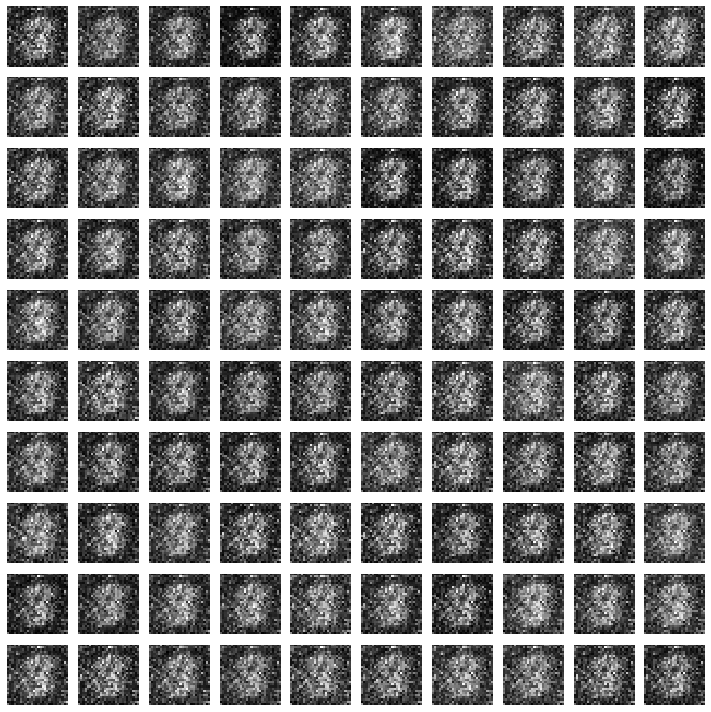

Batch NO : 0 Generator_Loss : 0.9452 Discriminator_Loss : 0.6499 
Batch NO : 10 Generator_Loss : 1.0134 Discriminator_Loss : 0.6058 
Batch NO : 20 Generator_Loss : 0.8723 Discriminator_Loss : 0.6593 
Batch NO : 30 Generator_Loss : 0.8871 Discriminator_Loss : 0.6617 
Batch NO : 40 Generator_Loss : 0.8205 Discriminator_Loss : 0.6545 
Batch NO : 50 Generator_Loss : 0.8688 Discriminator_Loss : 0.6218 
Batch NO : 60 Generator_Loss : 0.8809 Discriminator_Loss : 0.6708 
Batch NO : 70 Generator_Loss : 0.8190 Discriminator_Loss : 0.6670 
Batch NO : 80 Generator_Loss : 0.8613 Discriminator_Loss : 0.7100 
Batch NO : 90 Generator_Loss : 0.9851 Discriminator_Loss : 0.6495 
Batch NO : 100 Generator_Loss : 0.8928 Discriminator_Loss : 0.6524 
Batch NO : 110 Generator_Loss : 1.0182 Discriminator_Loss : 0.6403 
Batch NO : 120 Generator_Loss : 0.9578 Discriminator_Loss : 0.6839 
Batch NO : 130 Generator_Loss : 1.0687 Discriminator_Loss : 0.6892 
Batch NO : 140 Generator_Loss : 0.9337 Discriminator_Loss :

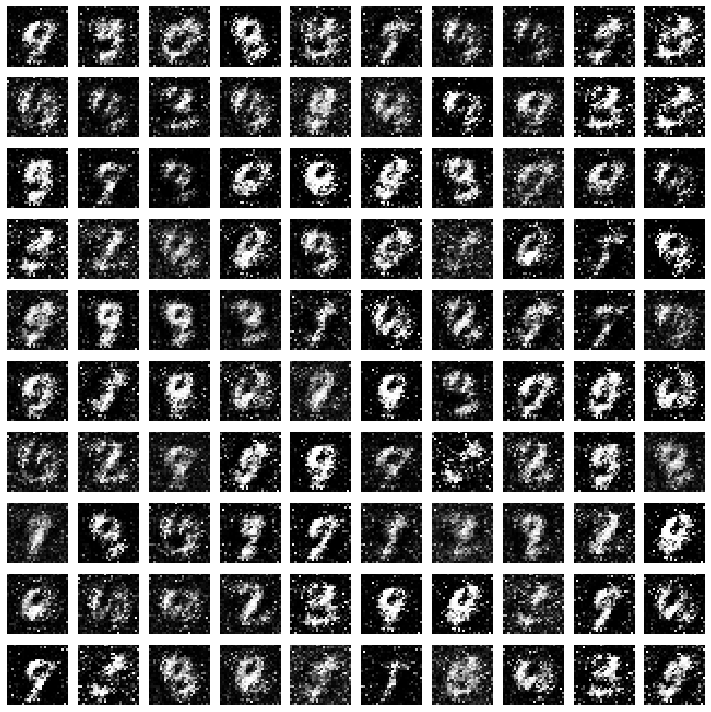

Batch NO : 0 Generator_Loss : 1.2407 Discriminator_Loss : 0.6033 
Batch NO : 10 Generator_Loss : 1.1642 Discriminator_Loss : 0.6250 
Batch NO : 20 Generator_Loss : 1.1640 Discriminator_Loss : 0.6108 
Batch NO : 30 Generator_Loss : 1.1845 Discriminator_Loss : 0.5899 
Batch NO : 40 Generator_Loss : 1.1860 Discriminator_Loss : 0.6093 
Batch NO : 50 Generator_Loss : 1.1575 Discriminator_Loss : 0.5866 
Batch NO : 60 Generator_Loss : 1.1814 Discriminator_Loss : 0.6010 
Batch NO : 70 Generator_Loss : 1.1850 Discriminator_Loss : 0.6009 
Batch NO : 80 Generator_Loss : 1.1976 Discriminator_Loss : 0.5715 
Batch NO : 90 Generator_Loss : 1.1234 Discriminator_Loss : 0.5997 
Batch NO : 100 Generator_Loss : 1.1067 Discriminator_Loss : 0.6399 
Batch NO : 110 Generator_Loss : 1.1027 Discriminator_Loss : 0.6281 
Batch NO : 120 Generator_Loss : 1.1128 Discriminator_Loss : 0.6169 
Batch NO : 130 Generator_Loss : 1.1438 Discriminator_Loss : 0.5930 
Batch NO : 140 Generator_Loss : 1.1781 Discriminator_Loss :

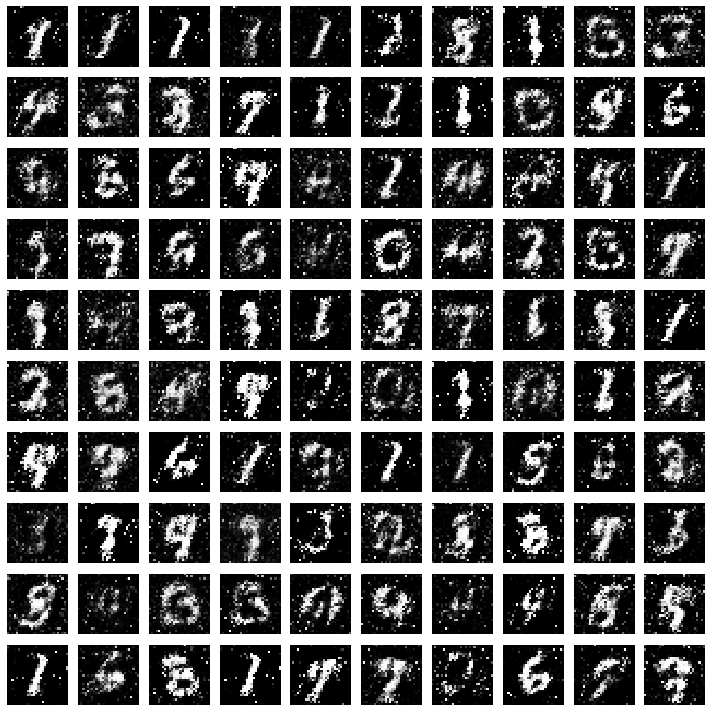

Batch NO : 0 Generator_Loss : 1.1010 Discriminator_Loss : 0.6149 
Batch NO : 10 Generator_Loss : 1.1355 Discriminator_Loss : 0.5957 
Batch NO : 20 Generator_Loss : 1.1326 Discriminator_Loss : 0.6166 
Batch NO : 30 Generator_Loss : 1.0808 Discriminator_Loss : 0.6364 
Batch NO : 40 Generator_Loss : 1.0644 Discriminator_Loss : 0.6365 
Batch NO : 50 Generator_Loss : 1.1185 Discriminator_Loss : 0.6412 
Batch NO : 60 Generator_Loss : 1.1240 Discriminator_Loss : 0.6483 
Batch NO : 70 Generator_Loss : 1.1065 Discriminator_Loss : 0.6612 
Batch NO : 80 Generator_Loss : 1.1297 Discriminator_Loss : 0.6197 
Batch NO : 90 Generator_Loss : 1.0739 Discriminator_Loss : 0.6327 
Batch NO : 100 Generator_Loss : 1.0752 Discriminator_Loss : 0.6531 
Batch NO : 110 Generator_Loss : 1.1030 Discriminator_Loss : 0.6470 
Batch NO : 120 Generator_Loss : 1.0789 Discriminator_Loss : 0.6177 
Batch NO : 130 Generator_Loss : 1.0530 Discriminator_Loss : 0.6278 
Batch NO : 140 Generator_Loss : 1.0395 Discriminator_Loss :

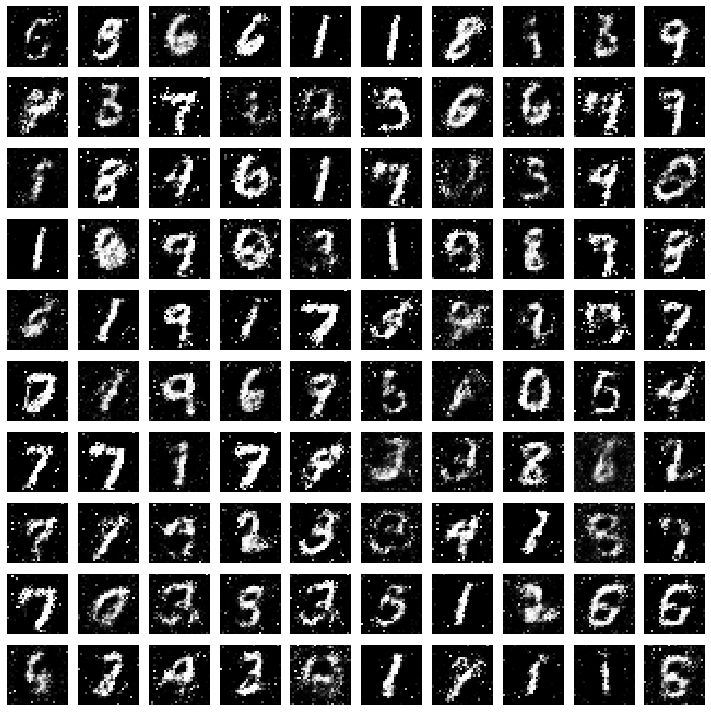

Batch NO : 0 Generator_Loss : 0.9634 Discriminator_Loss : 0.6597 
Batch NO : 10 Generator_Loss : 0.9502 Discriminator_Loss : 0.6453 
Batch NO : 20 Generator_Loss : 0.9494 Discriminator_Loss : 0.6557 
Batch NO : 30 Generator_Loss : 0.9939 Discriminator_Loss : 0.6526 
Batch NO : 40 Generator_Loss : 0.9590 Discriminator_Loss : 0.6608 
Batch NO : 50 Generator_Loss : 0.9861 Discriminator_Loss : 0.6743 
Batch NO : 60 Generator_Loss : 0.9651 Discriminator_Loss : 0.6691 
Batch NO : 70 Generator_Loss : 0.9701 Discriminator_Loss : 0.6535 
Batch NO : 80 Generator_Loss : 0.9914 Discriminator_Loss : 0.6673 
Batch NO : 90 Generator_Loss : 0.9693 Discriminator_Loss : 0.6601 
Batch NO : 100 Generator_Loss : 0.9979 Discriminator_Loss : 0.6501 
Batch NO : 110 Generator_Loss : 0.9853 Discriminator_Loss : 0.6568 
Batch NO : 120 Generator_Loss : 1.0206 Discriminator_Loss : 0.6594 
Batch NO : 130 Generator_Loss : 0.9723 Discriminator_Loss : 0.6658 
Batch NO : 140 Generator_Loss : 0.9668 Discriminator_Loss :

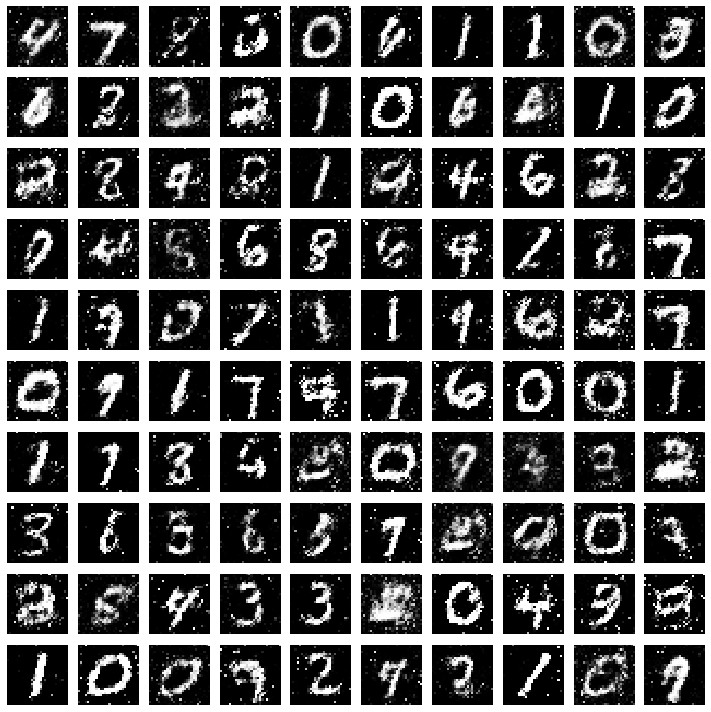

Batch NO : 0 Generator_Loss : 0.9980 Discriminator_Loss : 0.6427 
Batch NO : 10 Generator_Loss : 0.9691 Discriminator_Loss : 0.6564 
Batch NO : 20 Generator_Loss : 0.9285 Discriminator_Loss : 0.6568 
Batch NO : 30 Generator_Loss : 0.9409 Discriminator_Loss : 0.6650 
Batch NO : 40 Generator_Loss : 0.9360 Discriminator_Loss : 0.6723 
Batch NO : 50 Generator_Loss : 0.9486 Discriminator_Loss : 0.6671 
Batch NO : 60 Generator_Loss : 0.9390 Discriminator_Loss : 0.6738 
Batch NO : 70 Generator_Loss : 0.9329 Discriminator_Loss : 0.6825 
Batch NO : 80 Generator_Loss : 0.9497 Discriminator_Loss : 0.6822 
Batch NO : 90 Generator_Loss : 0.9780 Discriminator_Loss : 0.6531 
Batch NO : 100 Generator_Loss : 0.9721 Discriminator_Loss : 0.6643 
Batch NO : 110 Generator_Loss : 1.0278 Discriminator_Loss : 0.6280 
Batch NO : 120 Generator_Loss : 0.9576 Discriminator_Loss : 0.6723 
Batch NO : 130 Generator_Loss : 0.9853 Discriminator_Loss : 0.6673 
Batch NO : 140 Generator_Loss : 0.9629 Discriminator_Loss :

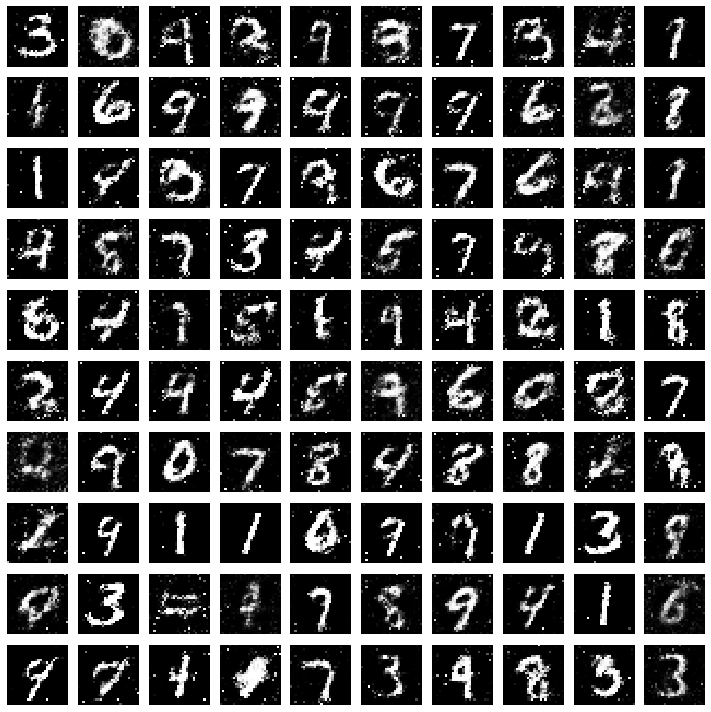

Batch NO : 0 Generator_Loss : 0.9585 Discriminator_Loss : 0.6707 
Batch NO : 10 Generator_Loss : 0.9452 Discriminator_Loss : 0.6721 
Batch NO : 20 Generator_Loss : 0.9428 Discriminator_Loss : 0.6411 
Batch NO : 30 Generator_Loss : 0.9746 Discriminator_Loss : 0.6575 
Batch NO : 40 Generator_Loss : 0.9489 Discriminator_Loss : 0.6507 
Batch NO : 50 Generator_Loss : 0.9516 Discriminator_Loss : 0.6612 
Batch NO : 60 Generator_Loss : 0.9220 Discriminator_Loss : 0.6733 
Batch NO : 70 Generator_Loss : 0.9435 Discriminator_Loss : 0.6606 
Batch NO : 80 Generator_Loss : 0.9361 Discriminator_Loss : 0.6464 
Batch NO : 90 Generator_Loss : 0.9472 Discriminator_Loss : 0.6700 
Batch NO : 100 Generator_Loss : 0.9329 Discriminator_Loss : 0.6732 
Batch NO : 110 Generator_Loss : 0.9604 Discriminator_Loss : 0.6807 
Batch NO : 120 Generator_Loss : 0.9451 Discriminator_Loss : 0.6531 
Batch NO : 130 Generator_Loss : 0.9538 Discriminator_Loss : 0.6609 
Batch NO : 140 Generator_Loss : 0.9681 Discriminator_Loss :

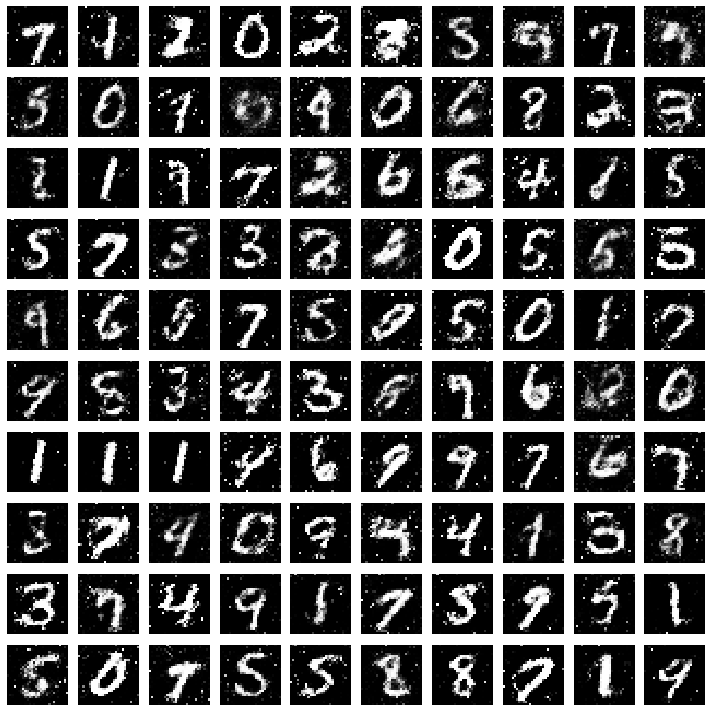

Batch NO : 0 Generator_Loss : 0.9840 Discriminator_Loss : 0.6584 
Batch NO : 10 Generator_Loss : 0.9349 Discriminator_Loss : 0.6655 
Batch NO : 20 Generator_Loss : 0.9566 Discriminator_Loss : 0.6851 
Batch NO : 30 Generator_Loss : 0.9356 Discriminator_Loss : 0.6738 
Batch NO : 40 Generator_Loss : 0.9566 Discriminator_Loss : 0.6653 
Batch NO : 50 Generator_Loss : 0.9501 Discriminator_Loss : 0.6884 
Batch NO : 60 Generator_Loss : 0.9390 Discriminator_Loss : 0.6778 
Batch NO : 70 Generator_Loss : 0.9747 Discriminator_Loss : 0.6619 
Batch NO : 80 Generator_Loss : 0.9370 Discriminator_Loss : 0.6502 
Batch NO : 90 Generator_Loss : 0.9447 Discriminator_Loss : 0.6770 
Batch NO : 100 Generator_Loss : 0.9693 Discriminator_Loss : 0.6509 
Batch NO : 110 Generator_Loss : 0.9493 Discriminator_Loss : 0.6808 
Batch NO : 120 Generator_Loss : 0.9850 Discriminator_Loss : 0.6785 
Batch NO : 130 Generator_Loss : 0.9616 Discriminator_Loss : 0.6762 
Batch NO : 140 Generator_Loss : 0.8977 Discriminator_Loss :

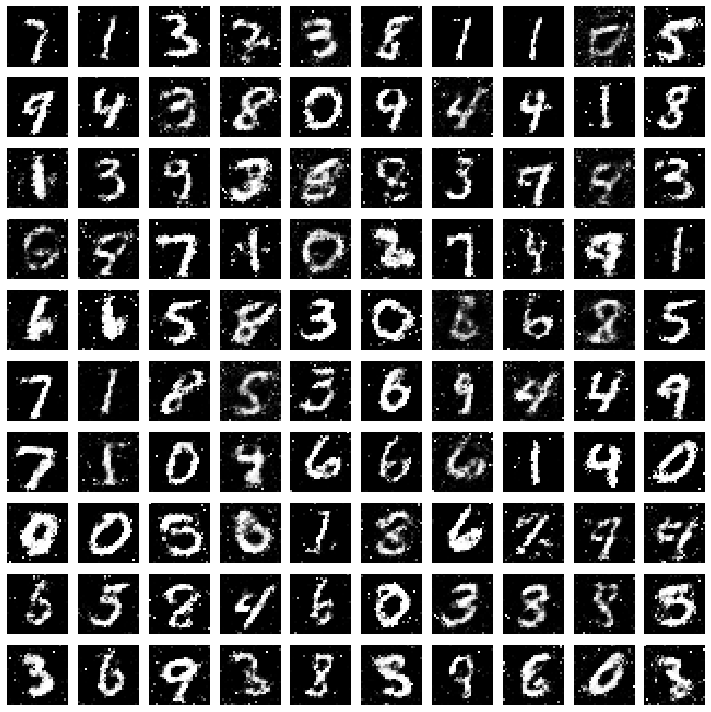

Batch NO : 0 Generator_Loss : 0.9578 Discriminator_Loss : 0.6552 
Batch NO : 10 Generator_Loss : 0.9377 Discriminator_Loss : 0.6837 
Batch NO : 20 Generator_Loss : 0.9524 Discriminator_Loss : 0.6790 
Batch NO : 30 Generator_Loss : 0.9062 Discriminator_Loss : 0.6707 
Batch NO : 40 Generator_Loss : 0.9567 Discriminator_Loss : 0.6602 
Batch NO : 50 Generator_Loss : 0.9374 Discriminator_Loss : 0.6666 
Batch NO : 60 Generator_Loss : 0.9255 Discriminator_Loss : 0.6704 
Batch NO : 70 Generator_Loss : 0.9237 Discriminator_Loss : 0.6775 
Batch NO : 80 Generator_Loss : 0.9386 Discriminator_Loss : 0.6846 
Batch NO : 90 Generator_Loss : 0.9700 Discriminator_Loss : 0.6697 
Batch NO : 100 Generator_Loss : 0.9393 Discriminator_Loss : 0.6579 
Batch NO : 110 Generator_Loss : 0.9775 Discriminator_Loss : 0.6775 
Batch NO : 120 Generator_Loss : 0.9406 Discriminator_Loss : 0.6661 
Batch NO : 130 Generator_Loss : 0.8921 Discriminator_Loss : 0.7057 
Batch NO : 140 Generator_Loss : 0.9113 Discriminator_Loss :

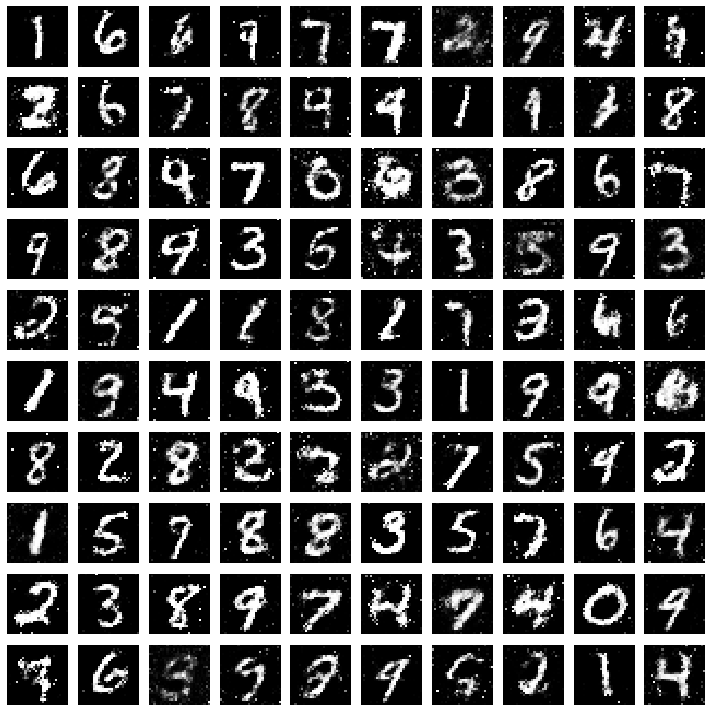

Batch NO : 0 Generator_Loss : 0.9130 Discriminator_Loss : 0.6658 
Batch NO : 10 Generator_Loss : 0.8891 Discriminator_Loss : 0.6844 
Batch NO : 20 Generator_Loss : 0.9353 Discriminator_Loss : 0.6701 
Batch NO : 30 Generator_Loss : 0.9750 Discriminator_Loss : 0.6813 
Batch NO : 40 Generator_Loss : 0.9587 Discriminator_Loss : 0.6705 
Batch NO : 50 Generator_Loss : 0.9285 Discriminator_Loss : 0.6816 
Batch NO : 60 Generator_Loss : 0.9070 Discriminator_Loss : 0.6608 
Batch NO : 70 Generator_Loss : 0.9296 Discriminator_Loss : 0.6650 
Batch NO : 80 Generator_Loss : 0.9197 Discriminator_Loss : 0.6802 
Batch NO : 90 Generator_Loss : 0.9818 Discriminator_Loss : 0.6643 
Batch NO : 100 Generator_Loss : 0.9070 Discriminator_Loss : 0.6722 
Batch NO : 110 Generator_Loss : 0.9316 Discriminator_Loss : 0.6854 
Batch NO : 120 Generator_Loss : 0.9576 Discriminator_Loss : 0.6916 
Batch NO : 130 Generator_Loss : 0.9904 Discriminator_Loss : 0.6682 
Batch NO : 140 Generator_Loss : 0.9347 Discriminator_Loss :

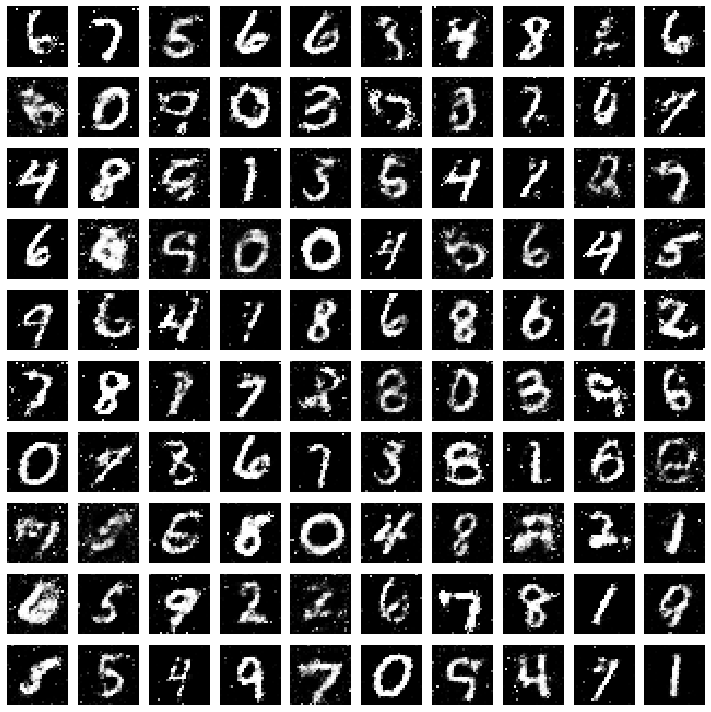

Batch NO : 0 Generator_Loss : 0.9808 Discriminator_Loss : 0.6731 
Batch NO : 10 Generator_Loss : 0.9395 Discriminator_Loss : 0.6887 
Batch NO : 20 Generator_Loss : 0.9531 Discriminator_Loss : 0.6837 
Batch NO : 30 Generator_Loss : 0.9684 Discriminator_Loss : 0.6756 
Batch NO : 40 Generator_Loss : 0.9526 Discriminator_Loss : 0.6589 
Batch NO : 50 Generator_Loss : 0.9046 Discriminator_Loss : 0.6790 
Batch NO : 60 Generator_Loss : 0.9164 Discriminator_Loss : 0.6884 
Batch NO : 70 Generator_Loss : 0.9843 Discriminator_Loss : 0.6623 
Batch NO : 80 Generator_Loss : 0.9447 Discriminator_Loss : 0.6681 
Batch NO : 90 Generator_Loss : 0.9388 Discriminator_Loss : 0.6772 
Batch NO : 100 Generator_Loss : 0.9388 Discriminator_Loss : 0.6589 
Batch NO : 110 Generator_Loss : 0.9188 Discriminator_Loss : 0.6860 
Batch NO : 120 Generator_Loss : 0.9232 Discriminator_Loss : 0.6629 
Batch NO : 130 Generator_Loss : 0.9166 Discriminator_Loss : 0.6738 
Batch NO : 140 Generator_Loss : 0.9159 Discriminator_Loss :

In [ ]:
for e in range(EPOCHS):
  g_loss = 0
  d_loss = 0
  for b in range(NO_BATCHES): 
    bg_loss = 0
    bd_loss = 0
    ## first step is to train discriminator 
    ## it takes H_BATCH real and fake images 
  
    ## taking randon H_BATCH images from dataset (train)
    ids = np.random.randint(0,train.shape[0],H_BATCH)
    realImages = train[ids]
    noiseSamples = np.random.normal(0,1,size = (H_BATCH,NOISE))
    fakeImages = generator.predict(noiseSamples)  ## for prediction it takes batch as input

    ## generating lables 
    realLables = np.ones((H_BATCH,1))*.9
    fakeLables = np.zeros((H_BATCH,1))

    ## training discriminator
    discriminator.trainable = True
    bd_loss += discriminator.train_on_batch(x = realImages,y = realLables)
    bd_loss += discriminator.train_on_batch(x = fakeImages,y = fakeLables) 
    bd_loss /= 2

    ## training generator 
    discriminator.trainable = False
    noiseSamples = np.random.normal(0,1,size=(BATCH_SIZE,NOISE))
    groundTruth = np.ones((BATCH_SIZE,1))

    bg_loss += model.train_on_batch(noiseSamples,groundTruth)
    g_loss += bg_loss
    d_loss += bd_loss
    if b%10 == 0: 
      print("Batch NO : %d Generator_Loss : %.4f Discriminator_Loss : %.4f " %(b,bg_loss,bd_loss))
  print("#######   Epoch : %d Generator_loss : %.4f Discriminator_loss : %.4f ############ " %(e,g_loss/NO_BATCHES,d_loss/NO_BATCHES))
  if(e%5 == 0):
    saveImage(e)

In [ ]:
!zip -r result.zip images
from google.colab import files
files.download('result.zip')

  adding: images/ (stored 0%)
  adding: images/outputAfterEpoch41.png (deflated 6%)
  adding: images/outputAfterEpoch46.png (deflated 5%)
  adding: images/outputAfterEpoch6.png (deflated 4%)
  adding: images/outputAfterEpoch1.png (deflated 3%)
  adding: images/outputAfterEpoch21.png (deflated 5%)
  adding: images/outputAfterEpoch31.png (deflated 5%)
  adding: images/outputAfterEpoch11.png (deflated 4%)
  adding: images/outputAfterEpoch16.png (deflated 4%)
  adding: images/outputAfterEpoch26.png (deflated 6%)
  adding: images/outputAfterEpoch36.png (deflated 5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# discriminator.trainable = True
# for e in range(EPOCHS):
#   g_loss = 0
#   d_loss = 0
#   for b in range(NO_BATCHES): 
#     bg_loss = 0
#     bd_loss = 0
#     ## first step is to train discriminator 
#     ## it takes H_BATCH real and fake images 
  
#     ## taking randon H_BATCH images from dataset (train)
#     ids = np.random.randint(0,train.shape[0],H_BATCH)
#     realImages = train[ids]
#     noiseSamples = np.random.normal(0,1,size = (H_BATCH,NOISE))
#     fakeImages = generator.predict(noiseSamples)  ## for prediction it takes batch as input

#     ## generating lables 
#     realLables = np.ones((H_BATCH,1))*.9
#     fakeLables = np.zeros((H_BATCH,1))

#     ## training discriminator
#     bd_loss += discriminator.train_on_batch(x = realImages,y = realLables)
#     bd_loss += discriminator.train_on_batch(x = fakeImages,y = fakeLables) 
#     bd_loss /= 2

#     ## training generator 
#     noiseSamples = np.random.normal(0,1,size=(BATCH_SIZE,NOISE))
#     groundTruth = np.ones((BATCH_SIZE,1))

#     bg_loss += model.train_on_batch(noiseSamples,groundTruth)
#     g_loss += bg_loss
#     d_loss += bd_loss
#     if b%10 == 0: 
#       print("Batch NO : %d Generator_Loss : %.4f Discriminator_Loss : %.4f " %(b,bg_loss,bd_loss))
#   print("#######   Epoch : %d Generator_loss : %.4f Discriminator_loss : %.4f ############ " %(e,g_loss/NO_BATCHES,d_loss/NO_BATCHES))

In [ ]:
# discriminator.trainable = False
# for e in range(EPOCHS):
#   g_loss = 0
#   d_loss = 0
#   for b in range(NO_BATCHES): 
#     bg_loss = 0
#     bd_loss = 0
#     ## first step is to train discriminator 
#     ## it takes H_BATCH real and fake images 
  
#     ## taking randon H_BATCH images from dataset (train)
#     ids = np.random.randint(0,train.shape[0],H_BATCH)
#     realImages = train[ids]
#     noiseSamples = np.random.normal(0,1,size = (H_BATCH,NOISE))
#     fakeImages = generator.predict(noiseSamples)  ## for prediction it takes batch as input

#     ## generating lables 
#     realLables = np.ones((H_BATCH,1))*.9
#     fakeLables = np.zeros((H_BATCH,1))

#     ## training discriminator
#     bd_loss += discriminator.train_on_batch(x = realImages,y = realLables)
#     bd_loss += discriminator.train_on_batch(x = fakeImages,y = fakeLables) 
#     bd_loss /= 2

#     ## training generator 
#     noiseSamples = np.random.normal(0,1,size=(BATCH_SIZE,NOISE))
#     groundTruth = np.ones((BATCH_SIZE,1))

#     bg_loss += model.train_on_batch(noiseSamples,groundTruth)
#     g_loss += bg_loss
#     d_loss += bd_loss
#     if b%10 == 0: 
#       print("Batch NO : %d Generator_Loss : %.4f Discriminator_Loss : %.4f " %(b,bg_loss,bd_loss))
#   print("#######   Epoch : %d Generator_loss : %.4f Discriminator_loss : %.4f ############ " %(e,g_loss/NO_BATCHES,d_loss/NO_BATCHES))
#   if(e%5 == 0):
#     saveImage(e)

In [ ]:
# noise = np.random.normal(0,1,size = (1,NOISE))
# generatedImage = generator.predict(noise)
# generatedImage

In [ ]:
# generatedImage = generatedImage.reshape((1,28,28))
# generatedImage = (generatedImage + 127.5)*127.5
# generatedImage[0]